In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

#using numpy
import numpy as np

#for data load or save
import pandas as pd

#visualize some datasets
import matplotlib.pyplot as plt

#check our work directory
import os

#to unzip datasets
import zipfile

In [2]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method
epochs = 10

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [90]:
base_dir = 'C:Users/Admin/Downloads/dogs-vs-cats'
train_dir = 'C:/Users/Admin/Downloads/dogs-vs-cats/CatDogF/train'
test_dir = 'C:/Users/Admin/Downloads/dogs-vs-cats/CatDogF/test'

'C:/Users/Admin/Downloads/dogs-vs-cats/CatDogF/test'

In [15]:
os.listdir(train_dir)[:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']

In [16]:
os.listdir(test_dir)[:5]

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg']

In [17]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [18]:
len(train_list)

25000

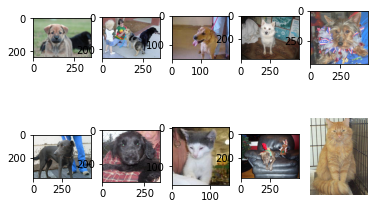

In [19]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [22]:
train_list[0].split('\\')[-1].split('.')[0]

'cat'

In [24]:
int(test_list[0].split('\\')[-1].split('.')[0])

1

In [25]:
print(len(train_list), len(test_list))

25000 12500


In [26]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [27]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [39]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'train\\dog':
            label=1
        elif label == 'train\\cat':
            label=0
            
        return img_transformed,label

In [40]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [41]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [42]:
print(len(train_data), len(train_loader))

20000 200


In [43]:
print(len(val_data), len(val_loader))

5000 50


In [44]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [65]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
           
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [66]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [67]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [70]:
epochs = 1

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.6964001655578613, train loss : 0.5787213444709778
Epoch : 1, val_accuracy : 0.7271999716758728, val_loss : 0.5452792644500732


In [71]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

In [75]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

In [76]:
submission = pd.DataFrame({'id':idx,'label':prob})

In [77]:
submission

,id,label
0,test\4035,0.097408
1,test\11322,0.761501
2,test\4294,0.693951
3,test\10942,0.530589
4,test\5241,0.541414
...,...,...
12495,test\8861,0.500756
12496,test\6033,0.375654
12497,test\472,0.604515
12498,test\11464,0.605825


In [78]:
submission.to_csv('result.csv',index=False)

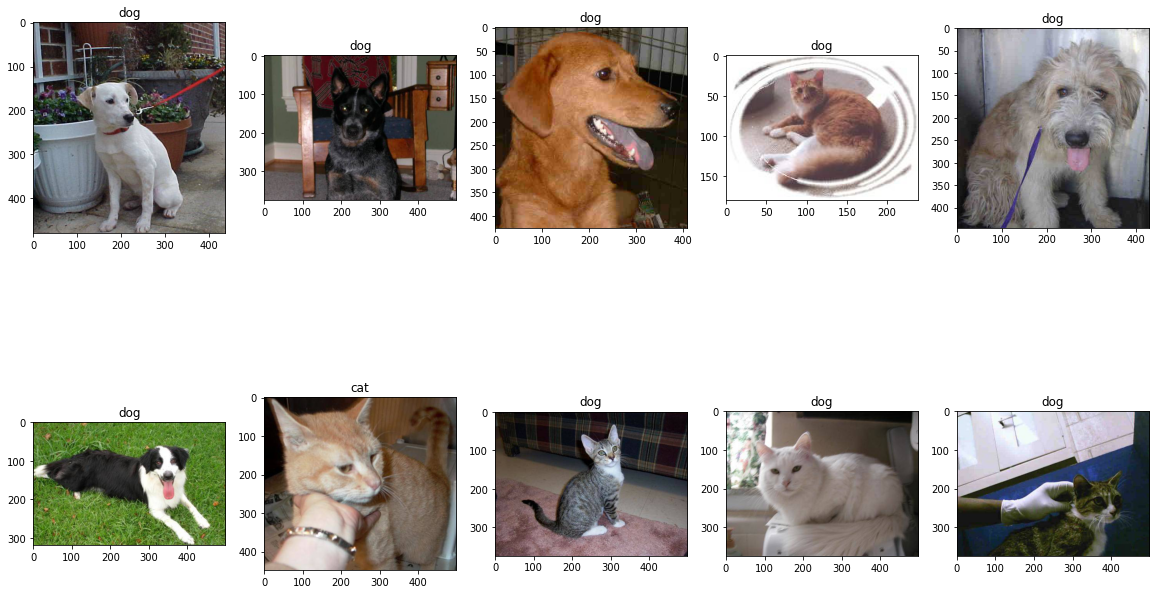

In [109]:
import random

test_dir1='C:/Users/Admin/Downloads/dogs-vs-cats/CatDogF'

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir1, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

In [86]:
test2='C:/Users/Admin/Downloads/dogs-vs-cats/CatDogF/test'

In [89]:
img_path

'C:/Users/Admin/Downloads/dogs-vs-cats/CatDogF/test\\test\\4861.jpg'

In [91]:
print(i)

test\4861


In [96]:
Cat=list(base_dir.glob("*.png"))
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    img=PIL.Image.open(str(Cat[i]))
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

AttributeError: 'str' object has no attribute 'glob'

In [98]:
print(dog_probs)

[('test\\4035', 0.0974084660410881), ('test\\11322', 0.7615013718605042), ('test\\4294', 0.6939506530761719), ('test\\10942', 0.5305885672569275), ('test\\5241', 0.5414142608642578), ('test\\8970', 0.3361038565635681), ('test\\1170', 0.6158663034439087), ('test\\9841', 0.796116828918457), ('test\\10002', 0.21529792249202728), ('test\\6640', 0.6914512515068054), ('test\\3508', 0.6674425601959229), ('test\\10262', 0.9980632662773132), ('test\\353', 0.4705198407173157), ('test\\12419', 0.27675020694732666), ('test\\4603', 0.9568428993225098), ('test\\4350', 0.9968106150627136), ('test\\9780', 0.3571633994579315), ('test\\986', 0.12099693715572357), ('test\\8095', 0.7236120104789734), ('test\\7822', 0.741554856300354), ('test\\483', 0.8448085188865662), ('test\\8496', 0.6535547375679016), ('test\\6478', 0.9261443614959717), ('test\\3882', 0.756016194820404), ('test\\1883', 0.6988919377326965), ('test\\9682', 0.6158900856971741), ('test\\9779', 0.7139703631401062), ('test\\1069', 0.51543956

In [99]:
len(train_data)

20000

In [100]:
len(val_data)

5000

In [101]:
len(test_data)

12500

In [103]:
print(id_list)

[]


In [104]:
print(label)

0


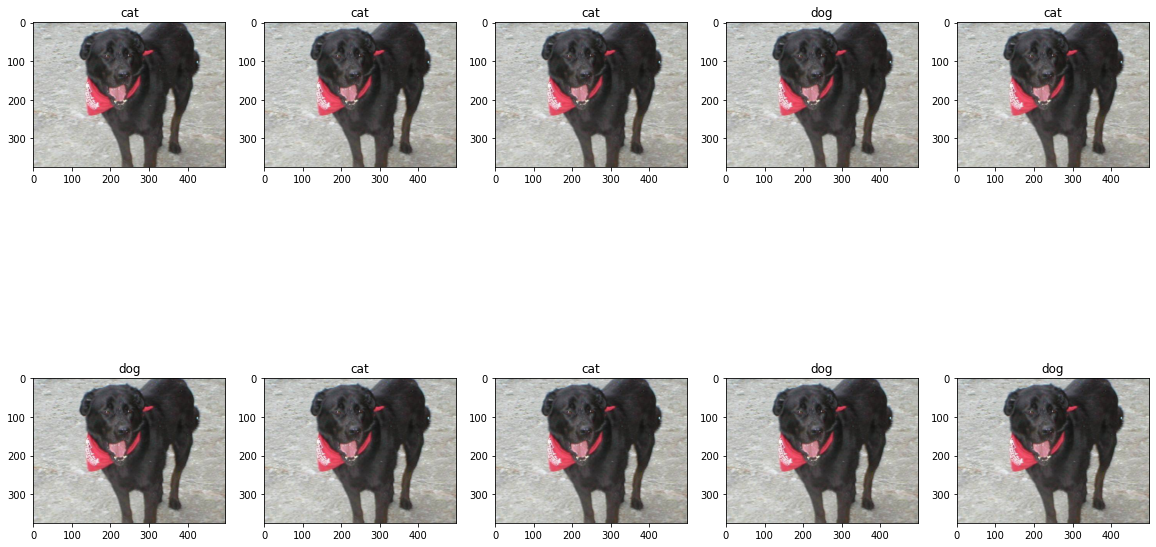

In [108]:
import random

test_dir1='C:/Users/Admin/Downloads/dogs-vs-cats/CatDogF'

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = "C:/Users/Admin/Downloads/dogs-vs-cats/CatDogF/test/12341.jpg"
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)